# Assignment 1: 3D Reconstruction via Triangulation

## Submission Guide

Submit the following:

- A well-commented codebase demonstrating each step of the reconstruction process, with explanations of each implementation step, results of each step (calibrated K matrix, distortion coefficients, number of matched features, etc.), and visualizations of the 3D point cloud. You are allowed to use built-in functions from OpenCV, but you must check the official documentation for any function you use and include an explanation of how it works in your implementation.
- Create a zip folder with your last name and send the assignment to me via Teams messages.

### Submission Deadline: 05/02/2025 @ 23:59

---

## Objective

This assignment involves extracting common feature points from two images using the SIFT algorithm and reconstructing a 3D scene based on these points. You will learn camera calibration, feature matching, fundamental and essential matrix computation, and triangulation.

---



# Steps

## 1. Camera Calibration
**Theory**: Camera calibration involves determining the intrinsic ($K$) and extrinsic ($R, t$) parameters of the camera. The intrinsic matrix $K$ is defined as:

$$
K = \begin{bmatrix}
f_x & 0 & c_x //
0 & f_y & c_y //
0 & 0 & 1
/end{bmatrix}
$$

where $f_x$ and $f_y$ are the focal lengths, and $(c_x, c_y)$ is the optical center. Distortion coefficients account for lens imperfections.

**Mathematics**:
- Use the chessboard pattern to obtain 2D image points and corresponding 3D object points. Chessboard images are provided in the "cal" folder.
- The calibration process minimizes the reprojection error defined as:

$$
/text{Error} = \sum \| P_{\text{projected}} - P_{\text{actual}} \|^2
$$

**Task**:
- Capture a series of images of a checkerboard pattern.
- Detect corners and compute the intrinsic parameters using OpenCV.

```python

import cv2
import numpy as np

# Load calibration images
# Detect checkerboard corners
ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)

# Prepare object points and image points
# Perform calibration using cv2.calibrateCamera
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Compute reprojection error
reprojection_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    reprojection_error += error
reprojection_error /= len(objpoints)
print("Reprojection error:", reprojection_error)

```
---


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


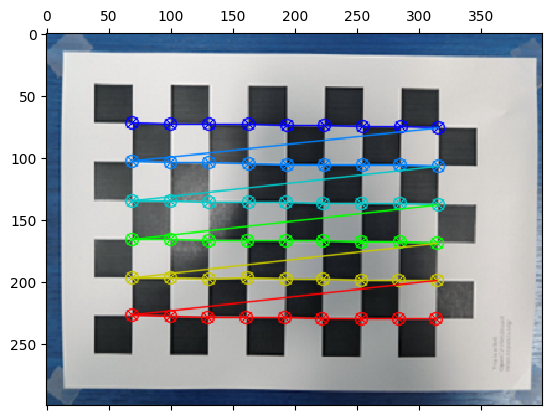

Image cal1 - Corners found
Reprojection error: 0.04444150909150552


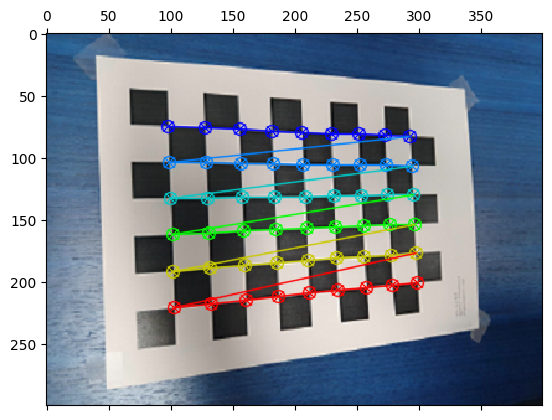

Image cal2 - Corners found
Reprojection error: 0.04525607073461614


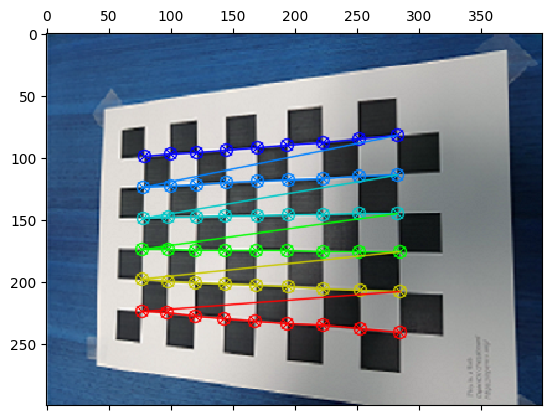

Image cal3 - Corners found
Reprojection error: 0.05094462512599118


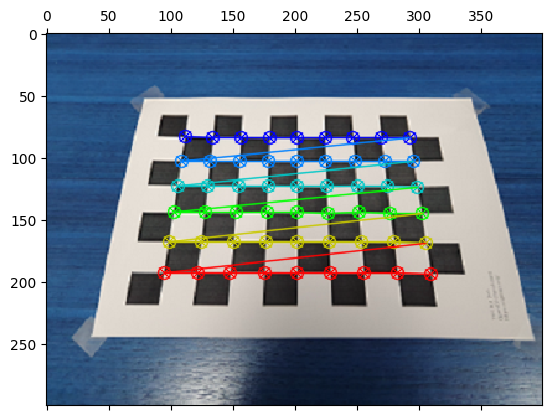

Image cal4 - Corners found
Reprojection error: 0.05065145740742498


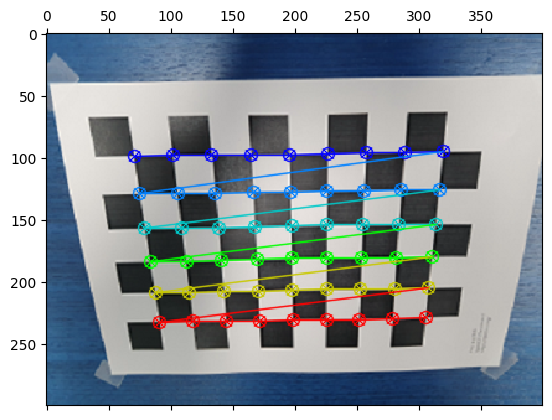

Image cal5 - Corners found
Reprojection error: 0.05317082232502113


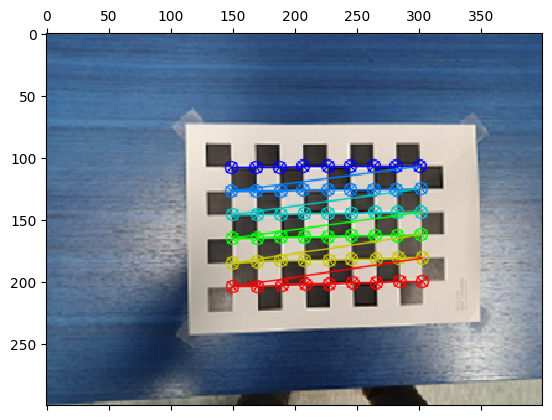

Image cal6 - Corners found
Reprojection error: 0.05866984251640798
Camera Matrix (Intrinsic Parameters):
[[308.31762471   0.         199.97713536]
 [  0.         309.46240975 144.61604099]
 [  0.           0.           1.        ]]
Focal Lengths: fx = 308.3176247061062, fy = 309.4624097506316
Optical Center: cx = 199.97713535832136, cy = 144.6160409888031


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

#CAMERA CALIBRATION

# Prepare object points (3D world coordinates)
objp = np.zeros((9 * 6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Lists to store object points and image points
objpoints = []  # 3D points
imgpoints = []  # 2D points


for i in range (1,7):
    img = cv2.imread(f"cal/cal{i}.png")
    # cv2.imshow(" Image", img)
    # cv2.waitKey(2000)

    if img is None:
        print(f"Could not load image: {i}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #cv2.imshow("Gray Image", gray)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('Checkerboard Detection', img)
        # cv2.waitKey(1000)
        #cv2.imwrite(f"Corners/cal{i}_corners.jpg", img)
        plt.matshow(img)
        plt.show()

    print(f"Image cal{i} - Corners {'found' if ret else 'not found'}")
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    reprojection_error = 0
    for j in range(len(objpoints)):

        imgpoints2, _ = cv2.projectPoints(objpoints[j], rvecs[j], tvecs[j], K, dist)
        error = cv2.norm(imgpoints[j], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        reprojection_error += error
    reprojection_error /= len(objpoints)
    print("Reprojection error:", reprojection_error)

cv2.destroyAllWindows()

print("Camera Matrix (Intrinsic Parameters):")
print(K)
f_x = K[0, 0]
f_y = K[1, 1]
c_x = K[0, 2]
c_y = K[1, 2]

print(f"Focal Lengths: fx = {f_x}, fy = {f_y}")
print(f"Optical Center: cx = {c_x}, cy = {c_y}")


## 2. Undistort Images
**Theory**: Lens distortion can cause straight lines to appear curved in images. The undistortion process corrects this, allowing for more accurate feature extraction.

**Task**:
- Use the intrinsic parameters to undistort your left (`left2`) and right (`right2`) images. These images are given in the "images" folder.

```python

# Undistort images using cv2.undistort

```
---


<function matplotlib.pyplot.show(close=None, block=None)>

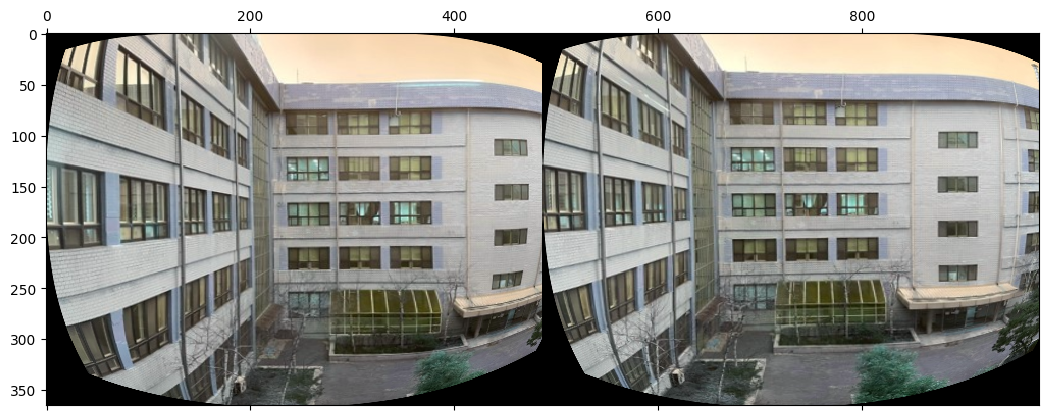

In [2]:
img = cv2.imread("Images/left2.jpg")

img1 = cv2.imread("Images/right2.jpg")

def undistort_image(image, K, dist):
    h, w = image.shape[:2]
    new_camera_matrix, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))
    undistorted = cv2.undistort(image, K, dist, None, new_camera_matrix)
    return undistorted

undistorted_img1 = undistort_image(img, K, dist)
undistorted_img2 = undistort_image(img1, K, dist)
combined_image = np.hstack((undistorted_img1,undistorted_img2))
#  cv2.imshow("Undistorted Images Side-by-Side", combined_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.matshow(combined_image)
plt.show


## 3. Feature Matching using SIFT
**Theory**: The SIFT (Scale-Invariant Feature Transform) algorithm extracts keypoints that are invariant to scale and rotation. Each keypoint has a descriptor that is robust to changes in lighting and perspective.

**Task**:
- Implement SIFT to extract keypoints and descriptors from the undistorted images.
- Use FLANN/Brute Force for feature matching and filter out good matches using Lowe’s ratio test:

$$
\frac{d_1}{d_2} < 0.75
$$

```python

# See the Feature Matching notebook I shared ;)

```
---

Number of good matches: 507


<function matplotlib.pyplot.show(close=None, block=None)>

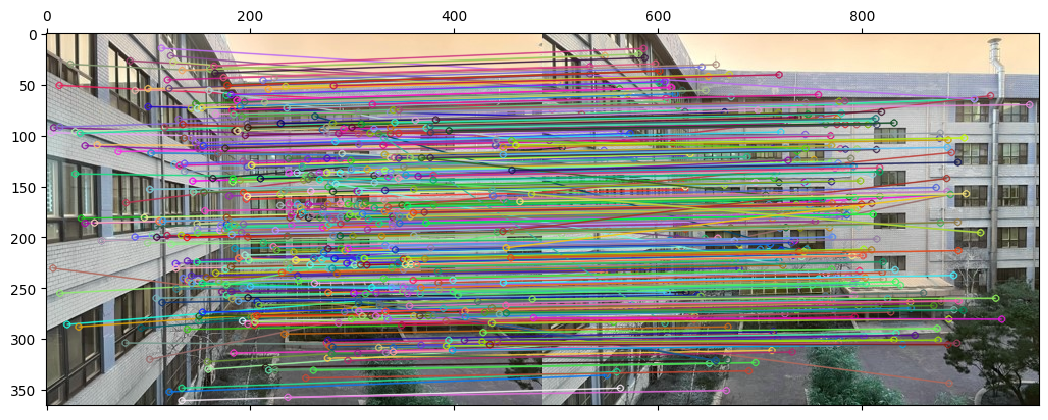

In [3]:
def match_features(image1, image2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    pts1, pts2 = [], []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            pts1.append(keypoints1[m.queryIdx].pt)
            pts2.append(keypoints2[m.trainIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return pts1, pts2, good_matches,keypoints1, keypoints2
pts1, pts2, good_matches, keypoints1, keypoints2 = match_features(cv2.cvtColor(undistorted_img1, cv2.COLOR_BGR2GRAY),cv2.cvtColor(undistorted_img2, cv2.COLOR_BGR2GRAY))
result_img = cv2.drawMatches(img, keypoints1, img1, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# cv2.imshow("SIFT Feature Matching", result_img)
# cv2.imwrite("SIFT_Feature_Matching.jpg", result_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(f"Number of good matches: {len(good_matches)}")
plt.matshow(result_img)
plt.show

## 4. Compute the Fundamental Matrix
**Theory**: The fundamental matrix $F$ relates corresponding points in stereo images, satisfying the epipolar constraint:

$$
\mathbf{p_2}^T F \mathbf{p_1} = 0
$$

**Task**:
- Calculate the fundamental matrix using the matched points and apply RANSAC for robustness.

```python

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
```
---

In [4]:
def compute_fundamental_matrix(pts1, pts2):
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    return F, pts1, pts2
F, pts1, pts2 = compute_fundamental_matrix(pts1, pts2)
print("Fundemental Matria",F)



Fundemental Matria [[ 3.51817901e-07 -2.24090310e-05  6.01795528e-03]
 [ 2.90014325e-05  2.31506417e-06  1.49463366e-02]
 [-7.39300309e-03 -1.90810523e-02  1.00000000e+00]]


## 5. Compute the Essential Matrix and Camera Pose
**Theory**: The essential matrix $E$ is derived from the fundamental matrix and intrinsic matrix:

$$
E = K^T F K
$$

**Task**:
- Calculate the essential matrix and recover the camera pose.

```python
E, _ = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC)
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
```
---

In [5]:
def compute_essential_matrix(pts1, pts2, K):
    E, _ = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    return E, R, t
E, R, t = compute_essential_matrix(pts1, pts2, K)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (t):\n", t.T)

Rotation Matrix (R):
 [[ 0.99933833 -0.0093148  -0.03515866]
 [ 0.00822572  0.9994857  -0.03099476]
 [ 0.03542929  0.03068504  0.99890099]]
Translation Vector (t):
 [[-9.87084213e-01 -3.53386026e-05 -1.60202234e-01]]


## 6. Triangulation
**Theory**: Triangulation computes the 3D position of points based on their 2D projections in two images. Given projection matrices $P_1$ and $P_2$:

$$
P = K[R|t]
$$

**Task**:
- Use the projection matrices to triangulate the 3D points.

```python
points_4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points_3D = points_4D[:3] / points_4D[3]
```
---

In [6]:
def triangulate_points(pts1, pts2, K, R, t):
    P1 = np.dot(K, np.hstack((np.eye(3), np.zeros((3, 1)))))
    P2 = np.dot(K, np.hstack((R, t)))

    pts4D = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

    # Filter valid points
    #valid_mask = np.isfinite(pts3D).all(axis=0)
    valid_mask = (np.abs(pts4D[3]) > 1e-6) & (pts4D[2] > -1.0) & np.isfinite(pts4D).all(axis=0)
    
    #pts3D = pts3D[:, valid_mask]
    points_3D = (pts4D[:3, valid_mask] / pts4D[3, valid_mask]).T
    points_3D = points_3D[np.isfinite(points_3D).all(axis=1)]  # Remove any remaining NaNs

    # if points_3D.shape[0] > 0:
    #    points_3D -= np.mean(points_3D, axis=0)  # Center the points
    #    points_3D /= np.max(np.linalg.norm(points_3D, axis=1))  # Normalize for visualization

     # Keeps only finite (valid) values
    valid_mask = np.isfinite(points_3D).all(axis=1) 
    points_clean = points_3D[valid_mask]   

    return points_clean
points_3D = triangulate_points(pts1, pts2, K, R, t)
print("Final 3D Points Shape:", points_3D.shape)
# print("First 5 points:\n", points_3D[:5]) 

# # Check for NaN values
# nan_mask = np.isnan(points_3D)
# print("Contains NaN values:", np.any(nan_mask))

# # Check for Inf values
# inf_mask = np.isinf(points_3D)
# print("Contains Inf values:", np.any(inf_mask))
# points_3D = np.array(points_3D, dtype=np.float64)
# print("First 20 points:\n", points_3D[:20])


Final 3D Points Shape: (175, 3)



## 7. Bundle Adjustment (Optional)
**Theory**: Bundle adjustment refines the 3D structure and camera parameters simultaneously to minimize the reprojection error.

**Task**:
- Implement bundle adjustment using optimization libraries (e.g., SciPy).

---

## 8. Visualization
**Theory**: Visualizing the reconstructed 3D points provides insights into the geometry of the scene.

**Task**:
- Use Open3D to visualize the reconstructed 3D point cloud.

```python
import open3d as o3d

# Create and visualize the point cloud using Open3D
```
---



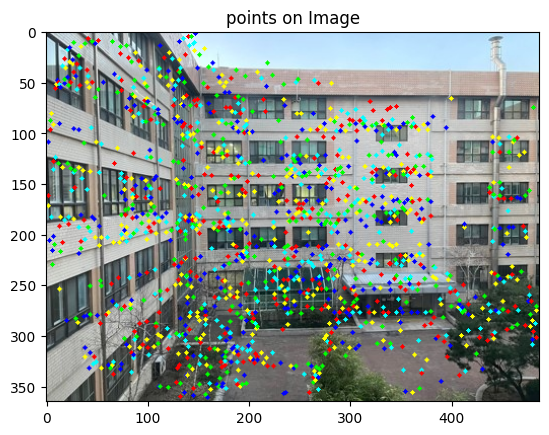

In [7]:
# Draw keypoints on the image
def draw_points(image, keypoints):
    output_image = image.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)] 
    for i, kp in enumerate(keypoints):
        x, y = int(kp.pt[0]), int(kp.pt[1])
        color = colors[i % len(colors)]  # Cycle through colors
        cv2.circle(output_image, (x, y), 2, color, -1)  # Smaller dots with varied colors
    return output_image


    # Draw keypoints on one of the images
keypoint_image = draw_points(img1, keypoints1)
plt.imshow(cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB))
plt.title("points on Image")
plt.show()




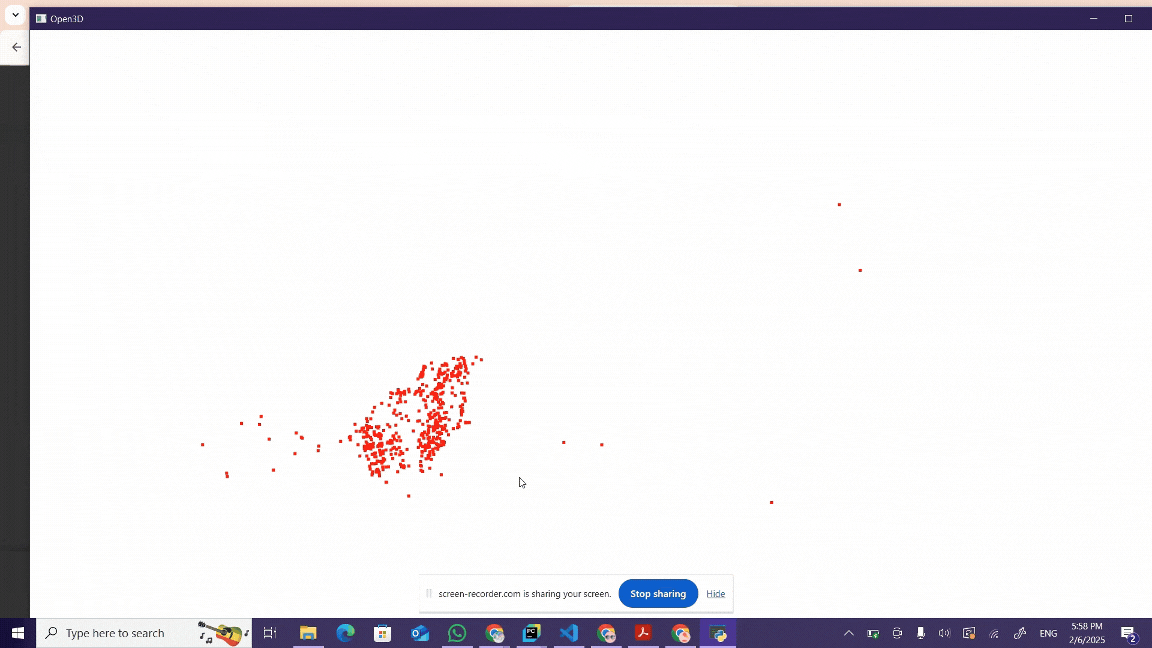

In [8]:
import os
from IPython.display import display, Image

# Set folder path
folder_path = "C:/Users/Mariam/Documents/VIBOT M1/S2/Computer Vision/Assignment 1 Sparse 3D Reconstruction/output"  # Change this to your folder path

# Get all image files
image_extensions = (".png", ".jpg", ".jpeg", ".gif")
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]

# Display images
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    display(Image(filename=image_path))